In [1]:
import sys
sys.path.append('../')

import warnings
warnings.filterwarnings("ignore")

from utils import *
from tqdm.auto import tqdm
import numpy as np
import pickle
import os
from model import probability_weighting

from experiment import unpack_and_dequantize

from matplotlib.colors import TwoSlopeNorm
import matplotlib.pyplot as plt
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({"font.size" : 15,
                     "figure.dpi" : 100, 
                     "grid.alpha" : 0.3, 
                     "axes.grid": False, 
                     "axes.axisbelow" : True,
                     "figure.figsize":(8,6),
                     "mathtext.fontset":"cm",
                     "xtick.labelsize": 14,
                     "ytick.labelsize": 14,
                     "axes.labelsize": 16, 
                     "legend.fontsize": 13.5})
plt.rc("text", usetex=False)
plt.rc("font", family="serif")

In [3]:
alpha_vals = np.linspace(0.3, 0.7, 16)
gamma_vals = np.linspace(0.3, 0.9, 16)

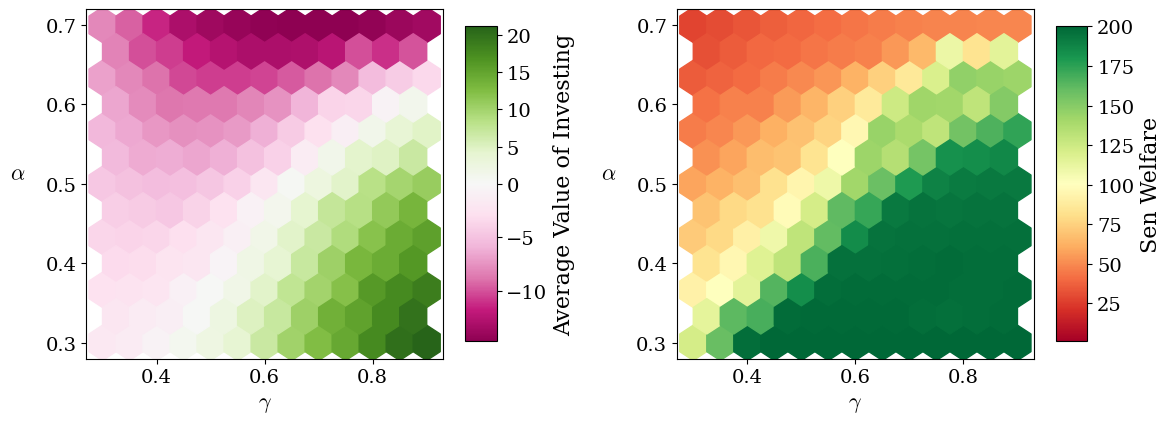

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4.5))

alpha_vals = np.linspace(0.3, 0.7, 16)
gamma_vals = np.linspace(0.3, 0.9, 16)

# Lists to store flattened data for hexbin
alphas = []
gammas = []
invest_values = []
welfare_values = []

# --- DATA LOADING ---
for f in os.listdir("../gamma_alpha"):
    try:
        parts = f.split("_")
        if len(parts) < 2: continue
        a_str, g_str = parts[:2]
        a, g = float(a_str), float(g_str)
        
        # Filter based on your original linspace range logic
        # Using a small epsilon for float comparison safety
        if (np.isclose(alpha_vals, a).any() and np.isclose(gamma_vals, g).any()):
            
            with open("../gamma_alpha/" + f, "rb") as file:
                data = pickle.load(file)
            
            # --- Process Invest Value ---
            inv = np.where(data["invest_val"] == -np.inf, -50, data["invest_val"])
            mean_inv = np.mean(inv)
            
            # --- Process Welfare ---
            wel = sen_welfare(
                utility(
                    unpack_and_dequantize(data["wealth"][:, -1], 200),
                    unpack_and_dequantize(data["health"][:, -1], 200),
                    alpha=a
                )
            )
            
            alphas.append(a)
            gammas.append(g)
            invest_values.append(mean_inv)
            welfare_values.append(wel)
            
    except ValueError:
        continue

# Convert to arrays for easier handling of mins/maxs
alphas = np.array(alphas)
gammas = np.array(gammas)
invest_values = np.array(invest_values)
welfare_values = np.array(welfare_values)

# --- PLOT 1: Invest Value ---
# Calculate norm based on the loaded data range
norm1 = TwoSlopeNorm(vcenter=0, vmin=invest_values.min(), vmax=invest_values.max())

# x=gammas, y=alphas (consistent with original code where gamma was x-axis)
hb1 = axs[0].hexbin(gammas, alphas, C=invest_values, 
                    gridsize=12, cmap="PiYG", norm=norm1, 
                    reduce_C_function=np.mean, mincnt=1)

axs[0].set_xlabel(r"$\gamma$")
axs[0].set_ylabel(r"$\alpha$", rotation=0, labelpad=20)
cbar1 = fig.colorbar(hb1, ax=axs[0], shrink=0.9, aspect=10, label="Average Value of Investing")

# --- PLOT 2: Welfare ---
norm2 = TwoSlopeNorm(vmin=0, vcenter=100, vmax=200)

hb2 = axs[1].hexbin(gammas, alphas, C=welfare_values, 
                    gridsize=12, cmap="RdYlGn", vmin=1, vmax=200, # or use norm=norm2
                    reduce_C_function=np.mean, mincnt=1)

axs[1].set_xlabel(r"$\gamma$")
axs[1].set_ylabel(r"$\alpha$", rotation=0, labelpad=20)
cbar2 = fig.colorbar(hb2, ax=axs[1], shrink=0.9, aspect=10, label="Sen Welfare")

fig.tight_layout()
plt.savefig("../figures/gamma_alpha.pdf", bbox_inches="tight")
plt.show()